# Training Variational Quantum Models with Barren Plateaus Mitigation Strategies
*Training QNN treated with method 3 (Identity Blocks) of the BP mitigation strategy (Cancer)*

**Authors:**
- Jacob Cybulski and Thanh Nguyen


In [1]:
from qiskit.providers.fake_provider import FakeAlmadenV2, FakeSherbrooke
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.primitives import Estimator, BackendEstimator
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient
from qiskit_machine_learning.connectors import TorchConnector

import torch
from torch import nn
from torch.nn import functional as F
from matplotlib import pyplot as plt
import pandas as pd


from Components.train import *
from Components.data import cancer_data
from Components.circuits import *
from Components.gradients import *
from Components.utils import *

from IPython.display import clear_output

In [2]:
from os.path import exists
from os import makedirs

In [3]:
# Global config for all experiments (data size, feature dim etc.) is stored here
from GLOBAL_CONFIG import *
# Remember to tag the method
METHOD_TAG = 'm3'

In [4]:
# backend = FakeSherbrooke()
# estimator = BackendEstimator(backend)
estimator = Estimator()

In [5]:
X_train, X_val, y_train, y_val = cancer_data(PCA_n = FEATURE_DIM)
# X_train, X_val, y_train, y_val = fetch_mnist(PCA_n = FEATURE_DIM, data_size=DATA_SIZE)
# X_train, X_val, y_train, y_val = iris(pd=False, PCA_n=None)

X_train_t = torch.from_numpy(X_train).to(torch.float32)
y_train_t = torch.from_numpy(y_train).to(torch.float32)
X_val_t = torch.from_numpy(X_val).to(torch.float32)
y_val_t = torch.from_numpy(y_val).to(torch.float32)

Training set: 398 samples
Testing set: 171 samples
Number of features: 4
PCA Explained variance: [4.43782605e+05 7.31010006e+03 7.03833742e+02 5.46487379e+01]
Classes:[0 1]; Encoded as: [-1  1]


In [6]:
if (exists(f'{LOG_PATH}/{METHOD_TAG}')):
    print(f'Found save folder: {LOG_PATH}/{METHOD_TAG}\n')
else:
    makedirs(f'{LOG_PATH}/{METHOD_TAG}')
    print(f'Creating save folder: {LOG_PATH}/{METHOD_TAG}\n')

Found save folder: ./Logs-Cancer-v4/m3



## Measuring Gradient Variance Decay

In [7]:
num_qubits = list(range(2, MAX_QUBITS))

# Globak operator for all ansatzes, measure all qubits
G_O = [SparsePauliOp.from_list([('Z'*n, 1)]) for n in num_qubits]

# Local operator for all ansatzes, measere 2 last qubits
L_O = [SparsePauliOp.from_list([('I' * (n - 2)+'Z'*2, 1)]) for n in num_qubits]

In [8]:
def sampleM3Var():
# Generate the pre-trained circuits
    pre_trained_block = [preTrainedBlockGenerator(n, int(np.floor(n/2))) for n in num_qubits]

    ansatzes_m3 = []
    for i in range(len(pre_trained_block)):
        ansatzes_m3.append(pre_trained_block[i]['circuit'])

    parameters_m3 = []
    for i in range(len(pre_trained_block)):
        parameters_m3.append(list(pre_trained_block[i]['params_values'].values()))

    gradients_m0 = sampleAnsatz(estimator, ansatzes_m3, G_O, parameters_m3)

    variance = getVariance(gradients_m0, num_qubits)
    
    return variance

## Cost Function Surface

In [9]:
feature_map = featureMapGenerator(FEATURE_DIM)
identity_block = preTrainedBlockGenerator(MAX_QUBITS_CLASSIFICATION, MAX_IDENTITIES_BLOCKS, overlay=IDENTITY_BLOCKS_OVERLAY, entanglement=ENTANGLEMENT, insert_barriers=True)
ansatz = identity_block['circuit']
qc=circuitBuilder(feature_map, ansatz)


id_dict = {k.name : v for k, v in identity_block['params_values'].items()}
initial_point = [id_dict[p.name] for p in list(ansatz.parameters)]

In [10]:
### Find what devices are available
from qiskit_aer.backends import AerSimulator
devices = AerSimulator().available_devices()
devices

# Force CPU - PyTorch+Qiskit too slow with GPU
devices = ('CPU')
devices

'CPU'

In [11]:
from qiskit.primitives import Estimator # For "CPU", ignores device="GPU" option
from qiskit_aer.primitives import Estimator as AerEstimator # For device="GPU" option

seed = 2023

# Use GPU when present, otherwise CPU
if 'GPU' in devices:
    device = 'GPU'
    estimator = AerEstimator(
        backend_options={'seed_simulator': seed, 'method': 'statevector', 
                         'device' : device, 'cuStateVec_enable' : True},
        run_options={'seed': seed, 'shots': 1000},
        transpile_options={"seed_transpiler": seed},
    )
else:
    device = 'CPU'
    estimator = Estimator()
    estimator.set_options(method='statevector')
    estimator.set_options(device=device)
    estimator.set_options(seed=seed)
    estimator.options

print(f'Selected device: {device}')

Selected device: CPU


In [12]:
res = pd.DataFrame()
epochs = 200

start = time.time()
for i in range(0, epochs):
    print('iteration: ', i)
    display(res)
    pertubated_initial_point = initial_point + np.random.uniform(-0.1, 0.1, ansatz.num_parameters)
    
    qnn = EstimatorQNN(
        circuit=qc,
        estimator=Estimator(),
        observables=GLOBAL_OPERATOR,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters
    )

    model = TorchConnector(qnn, initial_weights=pertubated_initial_point)

    loss_function = nn.L1Loss() #This is MAE loss
    optimizer = torch.optim.NAdam(model.parameters(), lr=0.05)

    loss, weight = sampleWeightLoss(
        model, 
        X_train_t,
        y_train_t,
        optimizer = optimizer, 
        loss_function = loss_function
        )
    res = pd.concat([res, pd.DataFrame(np.append(weight.numpy(), loss.numpy())).transpose()], ignore_index=True) 
    clear_output(wait=True)
elapsed = time.time() - start

pd.DataFrame(res).astype('float').to_csv(f'{LOG_PATH}/{METHOD_TAG}/LossFunctionSurface.csv')

iteration:  199


,0,1,2,3,4,5,6,7,8,9,...,105,106,107,108,109,110,111,112,113,114
0,5.487792,-1.505534,-2.504665,-3.458895,-5.951511,-2.914884,-4.706850,-1.420410,-2.661854,-4.440237,...,3.737351,2.293055,2.943687,-2.996067,-2.292723,-3.787663,-1.300771,-4.380367,2.808296,1.021588
1,5.433288,-1.442858,-2.540444,-3.288949,-5.975498,-2.905442,-4.639981,-1.557476,-2.808436,-4.384863,...,3.712218,2.170851,2.911173,-2.995150,-2.289525,-3.793350,-1.228401,-4.421679,2.718884,1.023915
2,5.455392,-1.344215,-2.584559,-3.442334,-6.137857,-2.746363,-4.597602,-1.536996,-2.739515,-4.500713,...,3.736284,2.308165,2.975864,-2.933644,-2.208870,-3.756489,-1.383808,-4.414723,2.801152,1.005023
3,5.533441,-1.367232,-2.562401,-3.434204,-6.092119,-2.848912,-4.693170,-1.529787,-2.690703,-4.476608,...,3.777019,2.192497,2.950533,-3.040712,-2.267810,-3.659122,-1.377158,-4.453643,2.756368,1.004665
4,5.515489,-1.416059,-2.571142,-3.276406,-6.089184,-2.837826,-4.667101,-1.582651,-2.712566,-4.510768,...,3.637214,2.131668,2.969872,-3.065372,-2.112505,-3.806562,-1.317582,-4.338269,2.735280,0.993413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,5.594234,-1.395971,-2.501971,-3.412992,-5.998414,-2.789903,-4.637191,-1.545024,-2.713896,-4.447947,...,3.664799,2.240102,3.098741,-3.086593,-2.288270,-3.629136,-1.388954,-4.403277,2.669654,0.999169
195,5.413118,-1.364920,-2.511380,-3.401000,-6.061061,-2.819947,-4.700641,-1.590777,-2.822722,-4.543393,...,3.714129,2.154325,3.018276,-2.974857,-2.118571,-3.762277,-1.276089,-4.507206,2.790775,1.003421
196,5.522332,-1.464299,-2.661034,-3.452497,-6.021887,-2.809072,-4.570302,-1.401770,-2.743622,-4.456235,...,3.822395,2.130923,3.001449,-2.927668,-2.110257,-3.661439,-1.367714,-4.501982,2.662185,1.024480
197,5.440982,-1.509181,-2.671400,-3.342391,-6.091752,-2.855191,-4.735628,-1.397712,-2.714710,-4.446727,...,3.822893,2.150291,2.912909,-2.991799,-2.120698,-3.682622,-1.378263,-4.446071,2.737435,1.004205


In [13]:
# Print run statistics
print(f'{device} Fit\n'+
      f'\tQubits:\t\t{len(ansatz.qubits)}\n'+
      f'\tId Blocks:\t\t{MAX_IDENTITIES_BLOCKS}\n'+
      f'\tWeights:\t{len(ansatz.parameters)}\n'+
      f'\tEpochs:\t\t{epochs})\n'+
      f'\tTime:\t\t{elapsed:0.2f} sec')

CPU Fit
	Qubits:		8
	Id Blocks:		3
	Weights:	114
	Epochs:		200)
	Time:		524.84 sec


## Measure Training Performance

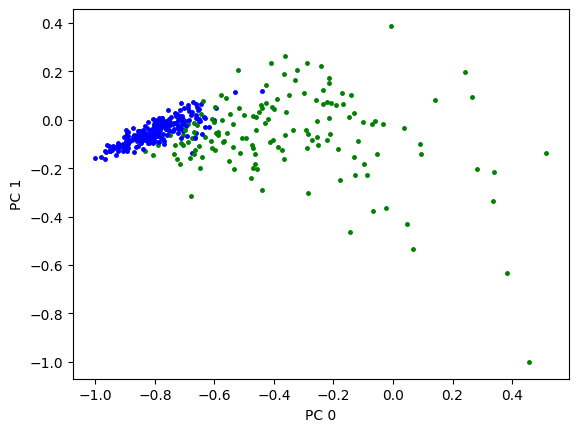

Blue: torch.Size([250])
Green: torch.Size([148])


In [14]:
# Plot dataset (only the first two args)
for x, y_target in zip(X_train_t, y_train_t):
    if y_target == 1:
        plt.plot(x[0], x[1], color="blue", marker=".", markersize=5)
    else:
        plt.plot(x[0], x[1], color="green", marker=".", markersize=5)
plt.xlabel('PC 0')
plt.ylabel('PC 1')
plt.show()

rows_b = np.where(np.array(y_train_t)==1)
rows_g = np.where(np.array(y_train_t)==-1)
print('Blue:', y_train_t[rows_b].size())
print('Green:', y_train_t[rows_g].size())

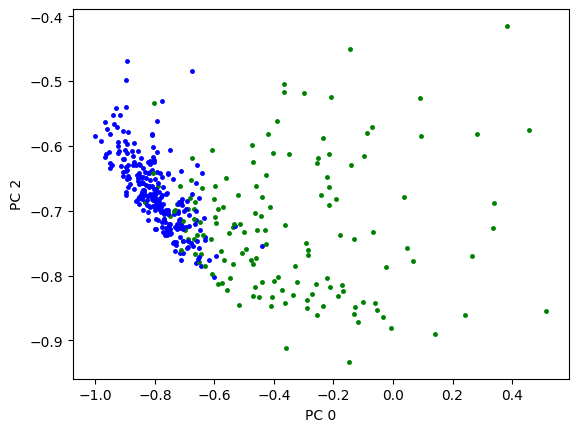

Blue: torch.Size([250])
Green: torch.Size([148])


In [15]:
# Plot dataset (only the first and the third arg)
for x, y_target in zip(X_train_t, y_train_t):
    if y_target == 1:
        plt.plot(x[0], x[2], color="blue", marker=".", markersize=5)
    else:
        plt.plot(x[0], x[2], color="green", marker=".", markersize=5)
plt.xlabel('PC 0')
plt.ylabel('PC 2')
plt.show()

rows_b = np.where(np.array(y_train_t)==1)
rows_g = np.where(np.array(y_train_t)==-1)
print('Blue:', y_train_t[rows_b].size())
print('Green:', y_train_t[rows_g].size())

In [16]:
feature_map = featureMapGenerator(FEATURE_DIM)
identity_block = preTrainedBlockGenerator(MAX_QUBITS_CLASSIFICATION, MAX_IDENTITIES_BLOCKS, overlay=IDENTITY_BLOCKS_OVERLAY, entanglement=ENTANGLEMENT, insert_barriers=True)
ansatz = identity_block['circuit']
qc=circuitBuilder(feature_map, ansatz)

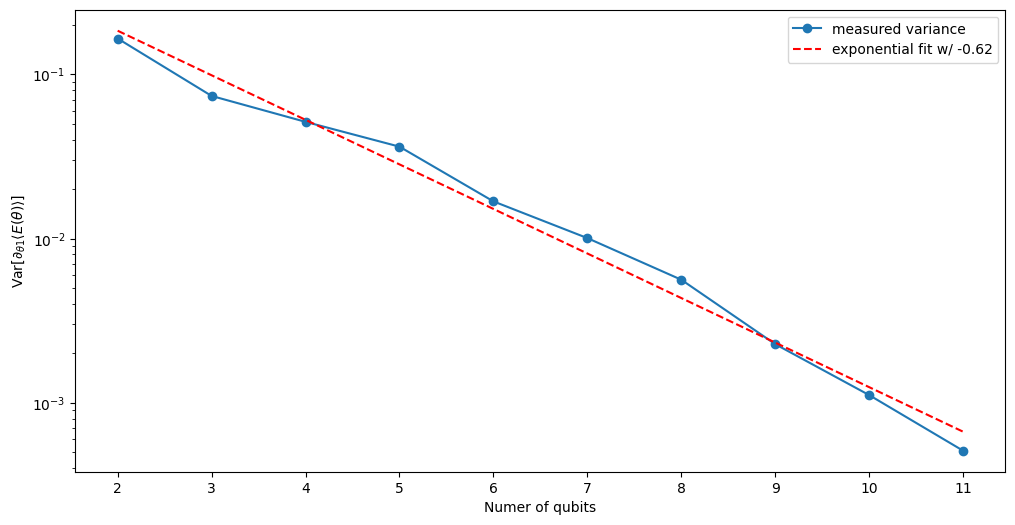

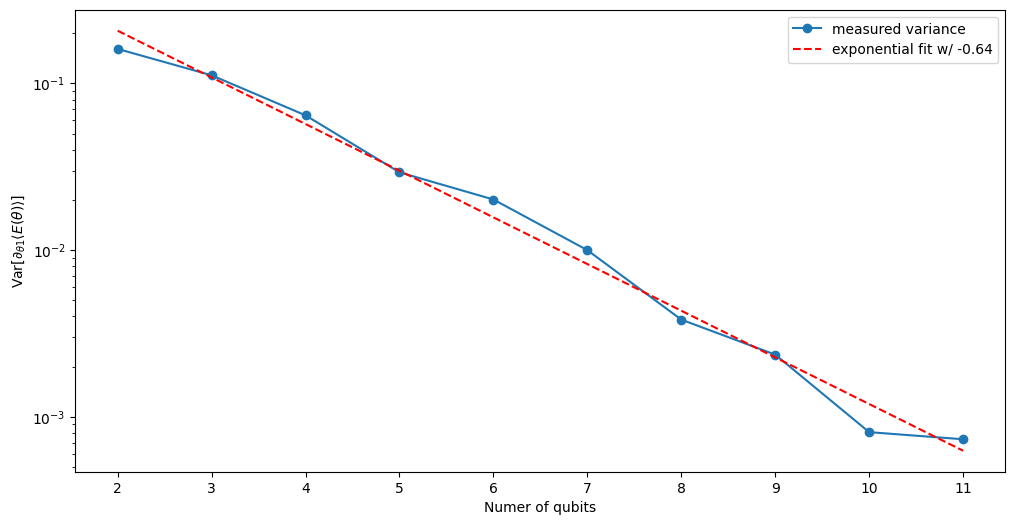

In [17]:
# To execute on multiple machines concurrently
# Select separate sub-lists of instance numbers and run
# Alternatively use range(MAX_INST) for all

m = METHOD_TAG
path = LOG_PATH
times = []

# for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]: 
for i in [2, 3]: 
    
    # Mark that the method's data has been saved
    if (exists(f'{path}/{m}')):
        print(f'Adding a new instance {i} of method {m}\n')
    else:
        makedirs(f'{path}/{m}')
        print(f'Creating the first instance {i} of method {m}\n')

    m3_variances = sampleM3Var()
        
    # The identity block returns parameters in order different to that in the ansatz
    identity_block = preTrainedBlockGenerator(MAX_QUBITS_CLASSIFICATION, MAX_IDENTITIES_BLOCKS, overlay=IDENTITY_BLOCKS_OVERLAY, entanglement=ENTANGLEMENT, insert_barriers=True)
    id_dict = {k.name : v for k, v in identity_block['params_values'].items()}
    initial_point = [id_dict[p.name] for p in list(ansatz.parameters)]

    # By default this will run as a local simulation
    qnn = EstimatorQNN(
        circuit=qc,
        estimator=Estimator(),
        observables=GLOBAL_OPERATOR,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters
    )

    model = TorchConnector(qnn, initial_weights=initial_point)

    loss_function = nn.L1Loss() # MSELoss()
    optimizer = torch.optim.NAdam(model.parameters(), lr=0.05)

    start = time.time()
    model, losses, accuracy_train, accuracy_test, weights = train(
        model, 
        MAX_ITER, 
        X_train_t,
        y_train_t,
        X_val_t,
        y_val_t,
        optimizer = optimizer, 
        loss_function = loss_function
        )
    elapsed = time.time() - start
    times.append(elapsed)

    pd.DataFrame(m3_variances, num_qubits).astype('float').to_csv(f'{path}/{m}/{m}-{i}-Variances.csv')
    pd.DataFrame(losses).astype('float').to_csv(f'{path}/{m}/{m}-{i}-LossFunction.csv')
    pd.DataFrame(accuracy_train).astype('float').to_csv(f'{path}/{m}/{m}-{i}-Scores-Train.csv')
    pd.DataFrame(accuracy_test).astype('float').to_csv(f'{path}/{m}/{m}-{i}-Scores-Test.csv')
    pd.DataFrame(weights).astype('float').to_csv(f'{path}/{m}/{m}-{i}-Weights.csv')
    
    # Mark that the method's data has been saved
    if (exists(f'{path}/{m}/{m}-Method.csv')):
        f = open(f'{path}/{m}/{m}-Method.csv', 'a')
    else:
        f = open(f'{path}/{m}/{m}-Method.csv', 'w')
        f.write(f'{m},Instance,Max Inst,Examples,Features,Iterations\n')
    f.write(f',{i},{MAX_INST},{DATA_SIZE},{FEATURE_DIM},{MAX_ITER}\n')
    f.close()
    
    clear_output(wait=True)

In [18]:
print(f'\nAverage time / instance: {np.average(times)}')


Average time / instance: 41933.1952599287


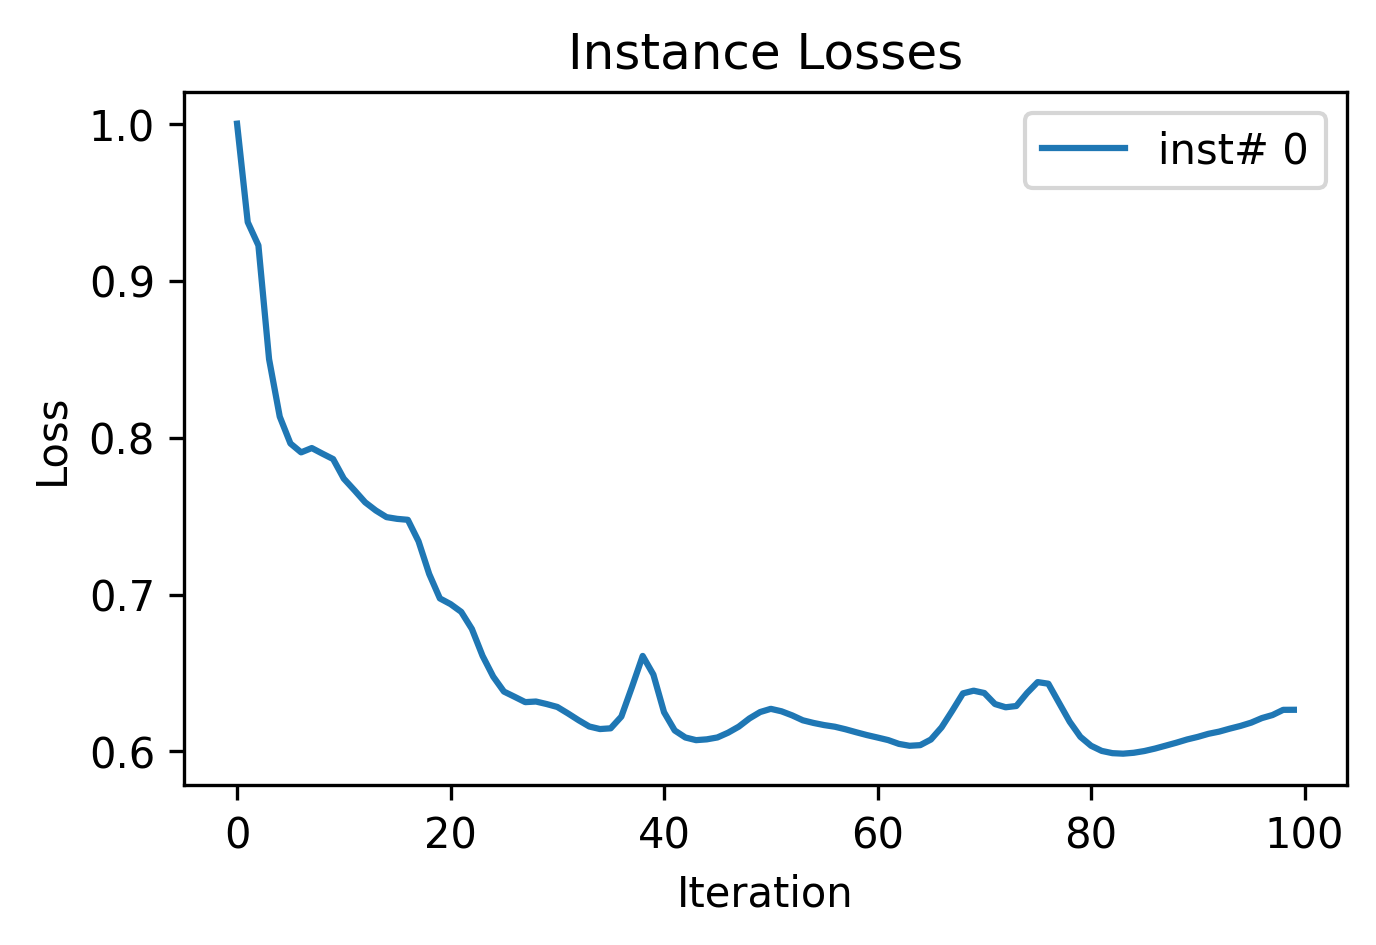

In [19]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

# Plot the loss of the last saved instance
plot_method_data([pd.DataFrame(losses).astype('float').T])

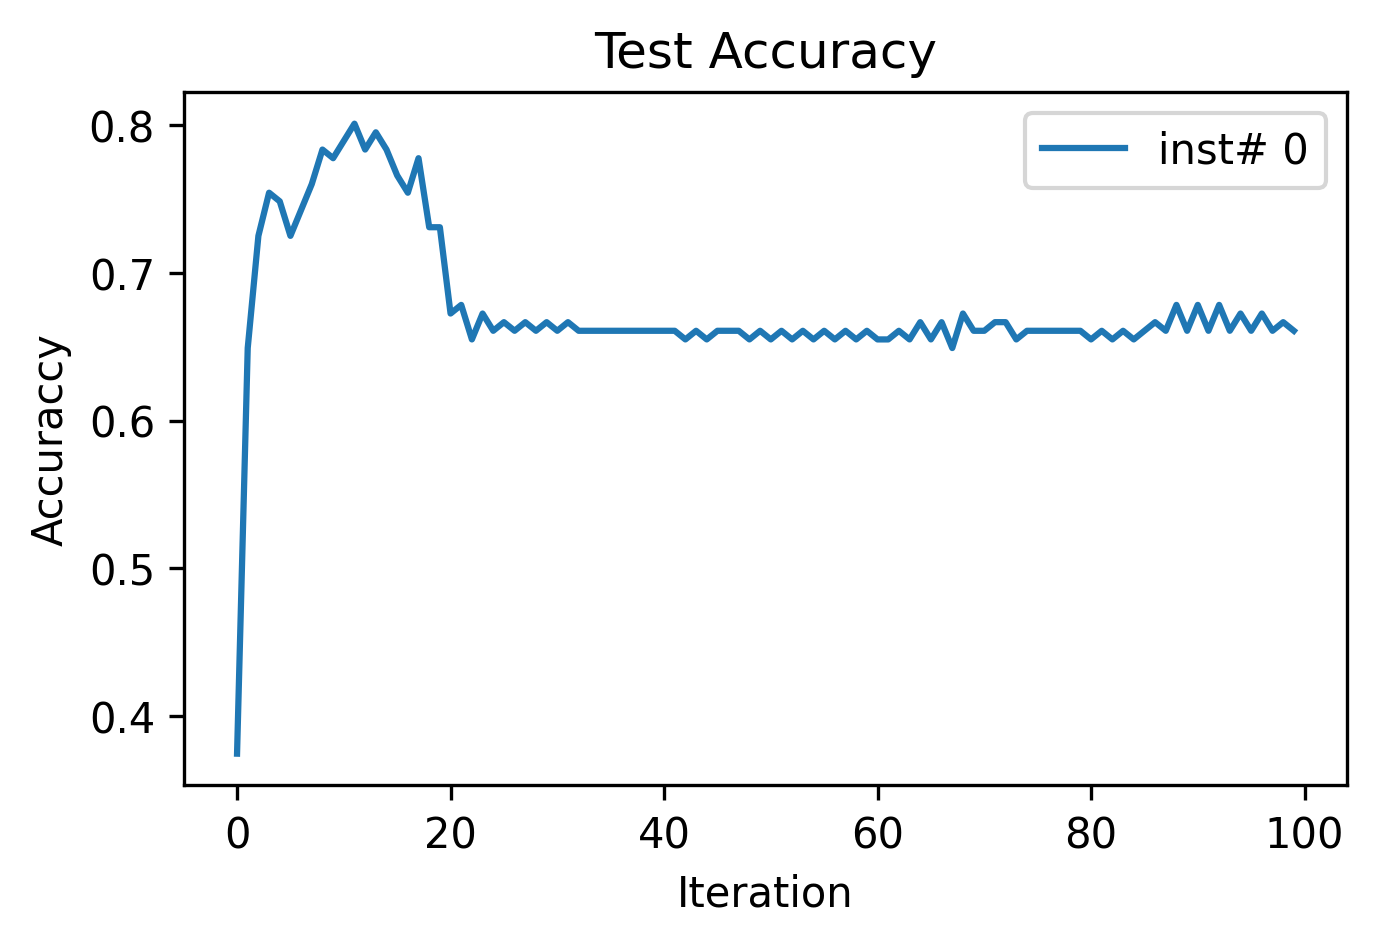

In [20]:
# Plot the loss of the last saved instance
plot_method_data([pd.DataFrame(accuracy_test).astype('float').T],
                title='Test Accuracy', dlabel='inst#', xlabel='Accuraccy', ylabel='Iteration')

In [21]:
!pip list | grep qiskit

qiskit                        0.45.2
qiskit-aer-gpu                0.13.2
qiskit-algorithms             0.2.2
qiskit-dynamics               0.4.3
qiskit-finance                0.4.0
qiskit-ibm-provider           0.6.3
qiskit-ibm-runtime            0.11.3
qiskit-ibmq-provider          0.20.2
qiskit-machine-learning       0.7.1
qiskit-nature                 0.7.1
qiskit-optimization           0.6.0
qiskit-qasm3-import           0.4.1
qiskit-sphinx-theme           1.12.1
qiskit-terra                  0.45.2


In [23]:
!pip list | grep torch

torch                         2.1.0
torchaudio                    2.1.0
torchsummary                  1.5.1
torchvision                   0.16.0
